In [2]:
# !pip install pyhrv
# !pip install pyarrow
# !pip install wfdb
# !pip install biosppy
# !pip install matplotlib
# !pip install numpy
# !pip install scipy
# !pip install nolds
# !pip install spectrum

In [3]:
!pip install cffi
!pip install --upgrade platformdirs
!pip list | grep platformdirs
!pip install --upgrade easydev

Requirement already up-to-date: platformdirs in /home/idies/miniconda3/lib/python3.8/site-packages (4.2.0)
platformdirs                       4.2.0
Requirement already up-to-date: easydev in /home/idies/miniconda3/lib/python3.8/site-packages (0.13.1)


In [4]:
# !pip install "colorama>=0.4.6,<0.5.0" --upgrade

In [5]:
# !pip install --upgrade "pexpect>=4.9.0,<5.0.0"

In [6]:
# !pip uninstall numpy
# !pip install "numpy<1.20"
# !pip uninstall pandas
# !pip install "pandas==1.3.0"

In [7]:
import numpy as np
print(np.__version__)

1.19.5


In [8]:
import pandas as pd
print(pd.__version__)

1.2.5


In [9]:
import pexpect
print(pexpect.__version__)

4.9.0


In [2]:
from matplotlib.figure import Figure
import json
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import math
import biosppy
import os
import collections
import warnings
import numpy as np
import pyarrow.parquet as pq

In [3]:
import pyhrv
import pyhrv.tools as tools
import pyhrv.time_domain as td
import pyhrv.frequency_domain as fd
import pyhrv.nonlinear as nl

In [12]:
import subprocess
import getpass
import os
from SciServer import Authentication
myUserName = Authentication.getKeystoneUserWithToken(Authentication.getToken()).userName
passwd = "westHopkins2442!"

userstring = "username=" + myUserName + ",workgroup=win,uid=idies,password=" + passwd
projectname = "LCICM"
dir = "//cloud.nas.jh.edu/sddesktop$/" + projectname

devnull = open(os.devnull, 'w')
subprocess.run(["sudo", "mkdir", "/home/idies/workspace/SAFE/"], capture_output=False)
subprocess.run(["sudo", "chown", "idies:idies", "/home/idies/workspace/SAFE/"], capture_output=False)
try:
    subprocess.run(["sudo", "mount", "-t", "cifs", dir, "/home/idies/workspace/SAFE/", "-o", userstring], stdout=devnull, stderr=devnull)
except FileNotFoundError as e:
    print(e)

In [13]:
def calc_features_helper(ecg_data):
    try:
        # calculate R peaks and NNI
        # NNI = normal to normal interval (between succesive R-peaks)
        rpeaks = biosppy.signals.ecg.christov_segmenter(ecg_data, sampling_rate = 500)[0]
        nni = tools.nn_intervals(rpeaks)

        # calculate time domain, freq domain, nonlinear features
        td_f = td.time_domain(nni).as_dict()
        nl_f = nl.nonlinear(nni).as_dict()

        # remove invalid vals
        feat = collections.OrderedDict(list(td_f.items()) + list(nl_f.items()))
        # keys that are known to produce inf or nan for our dataset
        for k in ["fft_bands", "lomb_bands", "ar_bands", "sdnn_index", "sdann", "sampen", "dfa_alpha1", "dfa_alpha1_beats", "dfa_alpha2", "dfa_alpha2_beats", "fft_plot","nni_histogram", "lomb_plot", "ar_plot", "poincare_plot", "dfa_plot", "tachogram_plot"]:
            feat.pop(k, 0)
        return feat
    except Exception as e:
        print(e)
        pass

In [14]:
def calc_features(ecg_path):
    plt.ioff()
    # ex ecg_path = "SAFE/Databases/mimic-iv-ecg-parquet/10400173/06:57:00_13_01_2128_10400173.parquet"
    # get 12-lead data from stored parquet
    ecg_raw = pq.read_table(ecg_path).to_pandas()

    # initialize pd df that'll contain features for all leads
    lead_features = {"I": calc_features_helper(pd.to_numeric(ecg_raw["I"], errors = "coerce")),
                    "II": calc_features_helper(pd.to_numeric(ecg_raw["II"], errors = "coerce")),
                    "III": calc_features_helper(pd.to_numeric(ecg_raw["III"], errors = "coerce")),
                    "aVR": calc_features_helper(pd.to_numeric(ecg_raw["aVR"], errors = "coerce")),
                    "aVL": calc_features_helper(pd.to_numeric(ecg_raw["aVL"], errors = "coerce")),
                    "aVF": calc_features_helper(pd.to_numeric(ecg_raw["aVF"], errors = "coerce")),
                    "V1": calc_features_helper(pd.to_numeric(ecg_raw["V1"], errors = "coerce")),
                    "V2": calc_features_helper(pd.to_numeric(ecg_raw["V2"], errors = "coerce")),
                    "V3": calc_features_helper(pd.to_numeric(ecg_raw["V3"], errors = "coerce")),
                    "V4": calc_features_helper(pd.to_numeric(ecg_raw["V4"], errors = "coerce")),
                    "V5": calc_features_helper(pd.to_numeric(ecg_raw["V5"], errors = "coerce")),
                    "V6": calc_features_helper(pd.to_numeric(ecg_raw["V6"], errors = "coerce"))}
    df = pd.DataFrame(lead_features)
    return df

In [15]:
os.getcwd()

'/home/idies/workspace/Storage/msyaile1/persistent/ecg_extraction'

In [16]:
import warnings
# quick test of calc features
warnings.filterwarnings("ignore")
df = calc_features("/home/idies/workspace/SAFE/Databases/mimic-iv-ecg-parquet/12839207/23:21:00_30_08_2164_12839207.parquet")
print (df)
print(df.shape)

                        I            II         III         aVR         aVL  \
nni_counter     13.000000     18.000000   13.000000   13.000000   13.000000   
nni_mean       357.615385    257.333333  357.692308  357.615385  357.769231   
nni_min        355.000000     68.000000  355.000000  339.000000  355.000000   
nni_max        361.000000    365.000000  362.000000  375.000000  361.000000   
hr_mean        167.782152    343.524957  167.746433  167.891721  167.711537   
hr_min         166.204986    164.383562  165.745856  160.000000  166.204986   
hr_max         169.014085    882.352941  169.014085  176.991150  169.014085   
hr_std           0.865873    264.327361    0.902396    4.556056    1.013953   
nni_diff_mean    1.500000    142.764706    1.666667   13.250000    2.500000   
nni_diff_min     0.000000      3.000000    0.000000    2.000000    0.000000   
nni_diff_max     4.000000    285.000000    5.000000   28.000000    5.000000   
sdnn             1.850156    118.053328    1.931520 

In [17]:
def flatten_matrix(df, id):
    reshaped = df.T.reset_index(drop=True)
    flattened = reshaped.values.flatten().tolist()
    flattened.insert(0, id)
    res = pd.DataFrame([flattened], index=[0], columns=cols_name)
    return res


In [18]:
# # for HF positive patients
# import csv

# # import CSV w/ list of all HF positive patient IDs
# pos_id = []
# pos_csv = open("hf_pt_id.csv", "r")
# for row in pos_csv:
#     pos_id.append(row[:])
# pos_id = pos_id[1:]
# print(len(set(pos_id)))

# # 8598 total pos HF patients

In [19]:
# pos_id[0:5]

In [20]:
# for HF positive patients
import csv

# import CSV w/ list of all HF positive ECG IDs
pos_ecg_id = []
pos_ecg_csv = open("/home/idies/workspace/SAFE/hf_ecg_list_id.csv", "r")
for row in pos_ecg_csv:
    row = row.strip()
    pos_ecg_id.append(row)
    
pos_ecg_id = pos_ecg_id[1:]
print(len(set(pos_ecg_id)))
print(pos_ecg_id[0:5])
# 5346 total pos HF patients' ECGs

21439
['13:45:00_11_01_2110_18106347', '15:43:00_13_01_2110_16284044', '04:02:00_17_01_2110_18780420', '08:05:00_19_01_2110_13201095', '02:02:00_22_01_2110_16006168']


In [21]:
pos_ecg_id[0:5]

['13:45:00_11_01_2110_18106347',
 '15:43:00_13_01_2110_16284044',
 '04:02:00_17_01_2110_18780420',
 '08:05:00_19_01_2110_13201095',
 '02:02:00_22_01_2110_16006168']

In [22]:
# ignoring the warnings that get generated from features that aren't being used in our model
warnings.filterwarnings("ignore")

# str_ex = "SAFE/Databases/mimic-iv-ecg-parquet/10400173/06:57:00_13_01_2128_10400173.parquet"



In [23]:
names = ['nni_counter', 'nni_mean', 'nni_min', 'nni_max', 'hr_mean', 'hr_min', 'hr_max', 'hr_std', 'nni_diff_mean', 'nni_diff_min', 'nni_diff_max', 'sdnn', 'rmssd', 'sdsd', 'nn50', 'pnn50', 'nn20', 'pnn20', 'tinn_n', 'tinn_m', 'tinn', 'tri_index', 'sd1', 'sd2', 'sd_ratio', 'ellipse_area']
cols_name = ["subject_id"]
count = 1
while count != 13:
    for name in names:
        cols_name.append(name + "_lead" + str(count))
    count+=1
print(len(cols_name))

313


In [24]:
!jupyter notebook --version


6.1.4


In [25]:
# (NOTE: Don't run this cell once extraction has started

# initialize feature table
# feature_table = pd.DataFrame([[0] * 313], columns=cols_name)
# print(feature_table)
# feature_table.to_csv("/home/idies/workspace/SAFE/new_advanced_ecg_features.csv", index=False)

In [26]:
# DON'T RUN ABOVE CELL

In [27]:
base_dir = r'/home/idies/workspace/SAFE/Databases/ecg_preprocessed'
extracted = []  # List of processed patient IDs to avoid reprocessing
pt_id = []

for filename in pos_ecg_id:
    # Extract patient ID from the filename
    pt_id.append(filename.split('_')[-1].split('.')[0].strip())  # Assumes patient ID is before the file extension and after the last underscore
    
print(pt_id[0:5])

['18106347', '16284044', '18780420', '13201095', '16006168']


In [28]:
extracted = pd.read_csv("/home/idies/workspace/SAFE/new_advanced_ecg_features.csv", usecols=["subject_id"])

In [29]:
extracted = extracted["subject_id"].tolist()
print(len(extracted))

18695


In [38]:
## ECG waveform not found for advance features extraction
not_extracted = [item for item in pos_ecg_id if item not in extracted]
print(not_extracted[0:5])
print(len(not_extracted))

['15:43:00_13_01_2110_16284044', '14:12:00_28_02_2117_16982032', '09:46:00_25_06_2128_16281507', '17:14:00_19_03_2144_16289850', '08:44:00_17_01_2151_16285428']
14


In [2]:
import psutil

# Get the memory usage in bytes
memory_usage = psutil.virtual_memory()
print(f"Total Memory: {memory_usage.total / (1024**3):.2f} GB")
print(f"Available Memory: {memory_usage.available / (1024**3):.2f} GB")


Total Memory: 157.42 GB
Available Memory: 99.55 GB


In [3]:
import psutil

# Get the memory usage in bytes
memory_usage = psutil.virtual_memory()
print(f"Total Memory: {memory_usage.total / (1024**3):.2f} GB")
print(f"Available Memory: {memory_usage.available / (1024**3):.2f} GB")

# Calculate used memory
used_memory = memory_usage.total - memory_usage.available
print(f"Used Memory: {used_memory / (1024**3):.2f} GB")

# Alternatively, use the 'used' attribute
print(f"Used Memory (direct): {memory_usage.used / (1024**3):.2f} GB")

Total Memory: 157.42 GB
Available Memory: 99.55 GB
Used Memory: 57.86 GB
Used Memory (direct): 56.55 GB


In [4]:
import gc
gc.collect()  # Force a garbage collection

54

In [16]:
process = psutil.Process()
print(f"Current Process Memory Usage: {process.memory_info().rss / (1024**3):.2f} GB")  # Resident Set Size

Current Process Memory Usage: 0.20 GB


In [35]:
# from tqdm import tqdm
# import os
# import pandas as pd
# from concurrent.futures import ProcessPoolExecutor

# # Assuming 'pos_ecg_id' and 'extracted' are defined
# # Ensure 'calc_features' and 'flatten_matrix' are optimized for performance

# base_dir = r'/home/idies/workspace/SAFE/ecg_preprocessed'
# curr_table_path = "/home/idies/workspace/SAFE/new_advanced_ecg_features.csv"

# # Function to process each file
# def process_file(filename):
#     file_path = os.path.join(base_dir, filename.strip())
#     if os.path.exists(file_path) and filename not in extracted:
#         features_full = calc_features(file_path)
#         features = flatten_matrix(features_full, filename).fillna(value=np.nan)
#         return features
#     return None

# # Initialize or load the existing table
# if os.path.exists(curr_table_path):
#     curr_table = pd.read_csv(curr_table_path)
# else:
#     curr_table = pd.DataFrame()

# # Process files in parallel
# with ProcessPoolExecutor() as executor:
#     results = list(tqdm(executor.map(process_file, pos_ecg_id), total=len(pos_ecg_id)))

# # Filter out None results and concatenate new features
# new_features = pd.concat([res for res in results if res is not None], ignore_index=True)
# new_table = pd.concat([curr_table, new_features])

# # Save the updated table
# new_table.to_csv(curr_table_path, index=False)


In [36]:
# from tqdm import tqdm
# import os

# base_dir = r'/home/idies/workspace/SAFE/ecg_preprocessed'
# curr_table_path = "/home/idies/workspace/SAFE/new_advanced_ecg_features.csv"

# # Assuming `pos_ecg_id` and `extracted` are defined somewhere in your code
# # Make sure to also define or import `calc_features` and `flatten_matrix` functions

# for filename in tqdm(pos_ecg_id):  # Wrap the loop with tqdm for a progress bar
#     filename = filename.strip()  # Trim whitespace and ensure the filename is clean

#     file_path = os.path.join(base_dir, filename)  # Construct the full file path

#     # Only print the file path if needed for debugging, otherwise comment it out
#     #print(f"Checking file: {file_path}")

#     if os.path.exists(file_path) and filename not in extracted:
#         # Uncomment the next line if you need to debug file processing
#         #print(f"Processing file: {file_path}")

#         features_full = calc_features(file_path)  # Extract features from the file

#         features = flatten_matrix(features_full, filename)  # Flatten and clean the features
#         features2 = features.fillna(value=np.nan)  # Handle NaN values

#         # Read the current table, or initialize it if it doesn't exist
#         if os.path.exists(curr_table_path):
#             curr_table = pd.read_csv(curr_table_path)
#         else:
#             curr_table = pd.DataFrame()

#         # Concatenate the new features and save the updated table
#         new_table = pd.concat([curr_table, features2])
#         new_table.to_csv(curr_table_path, index=False)

#         # Uncomment the next line if you need to see the updated table shape for debugging
#         # print(f"Updated table shape: {new_table.shape}")

#         extracted.append(filename)  # Mark this ID as processed to avoid reprocessing


In [39]:
import os

base_dir = r'/home/idies/workspace/SAFE/ecg_preprocessed'
curr_table_path =  "/home/idies/workspace/SAFE/new_advanced_ecg_features.csv"

for filename in pos_ecg_id:
#     print(f"Original filename from list: '{filename}'")  # Debug print

    # pt_id = filename.split('_')[-1].split('.')[0]  # Assumes patient ID is before the file extension and after the last underscore
    # print(f"Extracted pt_id: {pt_id}")
    
    # pt_id = pt_id.strip()  # Ensure pt_id is also stripped of whitespace and newline characters
    filename = filename.strip() # Trim whitespace and ensure the filename ends with '.parquet'
#     print(f"Extracted ecg: {filename}")
    
    # if not filename.endswith(".parquet"):
    #     filename += ".parquet"
    # print(f"Processed filename: '{filename}'") # Debug print to check the filename after processing
    
    file_path = os.path.join(base_dir, filename)  # Construct the full file path

#  print({file_path})
    
    if os.path.exists(file_path) and filename not in extracted:
        print(f"Processing file: {file_path}")

        # Extract features from the file
        features_full = calc_features(file_path)

        # Flatten and clean the features
        features = flatten_matrix(features_full, filename)
        features2 = features.fillna(value=np.nan)

        # Read the current table, or initialize it if it doesn't exist
        if os.path.exists(curr_table_path):
            curr_table = pd.read_csv(curr_table_path)
        else:
            curr_table = pd.DataFrame()

        # Concatenate the new features and save the updated table
        new_table = pd.concat([curr_table, features2])
        new_table.to_csv(curr_table_path, index=False)
#         print(f"Updated table shape: {new_table.shape}")

        # Mark this ID as processed to avoid reprocessing
        extracted.append(filename)

# Note: Ensure `calc_features` and `flatten_matrix` functions are defined to handle file paths and extract the required features.


In [40]:
label_hash_map = pd.read_csv('/home/idies/workspace/SAFE/label_hash_map.csv')
label_hash_map.head()

,formatted_time,hf,hf_type,label
0,13:45:00_11_01_2110_18106347,0,Non-HF,Non-HF wo BNP
1,15:43:00_13_01_2110_16284044,0,Non-HF,Non-HF wo BNP
2,04:02:00_17_01_2110_18780420,0,Non-HF,Non-HF wo BNP
3,08:05:00_19_01_2110_13201095,0,Non-HF,Non-HF wo BNP
4,02:02:00_22_01_2110_16006168,0,Non-HF,Non-HF wo BNP


In [41]:
print(label_hash_map.dtypes)

formatted_time    object
hf                 int64
hf_type           object
label             object
dtype: object


In [13]:
adv_features = pd.read_csv("/home/idies/workspace/SAFE/new_advanced_ecg_features.csv")

In [47]:
adv_features.head()

,subject_id,nni_counter_lead1,nni_mean_lead1,nni_min_lead1,nni_max_lead1,hr_mean_lead1,hr_min_lead1,hr_max_lead1,hr_std_lead1,nni_diff_mean_lead1,...,nn20_lead12,pnn20_lead12,tinn_n_lead12,tinn_m_lead12,tinn_lead12,tri_index_lead12,sd1_lead12,sd2_lead12,sd_ratio_lead12,ellipse_area_lead12
0,0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0000,0.0000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000
1,13:45:00_11_01_2110_18106347,14.0,326.285714,325.0,328.0,183.889253,182.926829,184.615385,0.514127,0.923077,...,0.0,0.000000,0.0000,0.0000,0.0000,1.00,1.382477,0.860026,0.622091,3.735248
2,04:02:00_17_01_2110_18780420,8.0,536.375000,282.0,741.0,126.013995,80.971660,212.765957,52.425849,250.571429,...,6.0,85.714286,539.0625,554.6875,15.6250,4.00,205.980879,122.749953,0.595929,79432.478675
3,08:05:00_19_01_2110_13201095,20.0,242.700000,175.0,297.0,252.807839,202.020202,342.857143,41.515091,39.421053,...,13.0,68.421053,234.3750,273.4375,39.0625,4.00,34.453630,32.666959,0.948143,3535.847814
4,02:02:00_22_01_2110_16006168,14.0,342.428571,338.0,347.0,175.232180,172.910663,177.514793,1.574611,2.153846,...,0.0,0.000000,328.1250,343.7500,15.6250,1.75,2.190620,3.947136,1.801835,27.164332


In [48]:
adv_features.shape

(21429, 313)

In [49]:
# Convert the Index object to a list and print it
print(list(adv_features.columns))

['subject_id', 'nni_counter_lead1', 'nni_mean_lead1', 'nni_min_lead1', 'nni_max_lead1', 'hr_mean_lead1', 'hr_min_lead1', 'hr_max_lead1', 'hr_std_lead1', 'nni_diff_mean_lead1', 'nni_diff_min_lead1', 'nni_diff_max_lead1', 'sdnn_lead1', 'rmssd_lead1', 'sdsd_lead1', 'nn50_lead1', 'pnn50_lead1', 'nn20_lead1', 'pnn20_lead1', 'tinn_n_lead1', 'tinn_m_lead1', 'tinn_lead1', 'tri_index_lead1', 'sd1_lead1', 'sd2_lead1', 'sd_ratio_lead1', 'ellipse_area_lead1', 'nni_counter_lead2', 'nni_mean_lead2', 'nni_min_lead2', 'nni_max_lead2', 'hr_mean_lead2', 'hr_min_lead2', 'hr_max_lead2', 'hr_std_lead2', 'nni_diff_mean_lead2', 'nni_diff_min_lead2', 'nni_diff_max_lead2', 'sdnn_lead2', 'rmssd_lead2', 'sdsd_lead2', 'nn50_lead2', 'pnn50_lead2', 'nn20_lead2', 'pnn20_lead2', 'tinn_n_lead2', 'tinn_m_lead2', 'tinn_lead2', 'tri_index_lead2', 'sd1_lead2', 'sd2_lead2', 'sd_ratio_lead2', 'ellipse_area_lead2', 'nni_counter_lead3', 'nni_mean_lead3', 'nni_min_lead3', 'nni_max_lead3', 'hr_mean_lead3', 'hr_min_lead3', 'hr_m

In [50]:
adv_features_labeled = pd.merge(adv_features, label_hash_map[['formatted_time', 'hf', 'hf_type']], \
                                left_on='subject_id', right_on='formatted_time', how='inner')

In [51]:
# Drop the 'formatted_time' column from the resulting DataFrame
adv_features_labeled = adv_features_labeled.drop('formatted_time', axis=1)

In [52]:
print(list(adv_features_labeled.columns))

['subject_id', 'nni_counter_lead1', 'nni_mean_lead1', 'nni_min_lead1', 'nni_max_lead1', 'hr_mean_lead1', 'hr_min_lead1', 'hr_max_lead1', 'hr_std_lead1', 'nni_diff_mean_lead1', 'nni_diff_min_lead1', 'nni_diff_max_lead1', 'sdnn_lead1', 'rmssd_lead1', 'sdsd_lead1', 'nn50_lead1', 'pnn50_lead1', 'nn20_lead1', 'pnn20_lead1', 'tinn_n_lead1', 'tinn_m_lead1', 'tinn_lead1', 'tri_index_lead1', 'sd1_lead1', 'sd2_lead1', 'sd_ratio_lead1', 'ellipse_area_lead1', 'nni_counter_lead2', 'nni_mean_lead2', 'nni_min_lead2', 'nni_max_lead2', 'hr_mean_lead2', 'hr_min_lead2', 'hr_max_lead2', 'hr_std_lead2', 'nni_diff_mean_lead2', 'nni_diff_min_lead2', 'nni_diff_max_lead2', 'sdnn_lead2', 'rmssd_lead2', 'sdsd_lead2', 'nn50_lead2', 'pnn50_lead2', 'nn20_lead2', 'pnn20_lead2', 'tinn_n_lead2', 'tinn_m_lead2', 'tinn_lead2', 'tri_index_lead2', 'sd1_lead2', 'sd2_lead2', 'sd_ratio_lead2', 'ellipse_area_lead2', 'nni_counter_lead3', 'nni_mean_lead3', 'nni_min_lead3', 'nni_max_lead3', 'hr_mean_lead3', 'hr_min_lead3', 'hr_m

In [53]:
adv_features_labeled['subject_id'].nunique()

21424

In [54]:
# Specify the file path
file_path = '/home/idies/workspace/SAFE/adv_features_labeled.csv'

# Save the DataFrame to a CSV file with column names
adv_features_labeled.to_csv(file_path, index=False)

[ 0.075  0.065  0.055 ... -0.02  -0.025 -0.025]


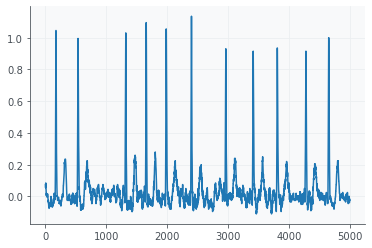

In [10]:
# sanityabove ecg lead visualized
# ecg_path = "/home/idies/workspace/SAFE/Databases/mimic-iv-ecg-parquet/10400173/06:57:00_13_01_2128_10400173.parquet"
record = wfdb.rdrecord("/home/idies/workspace/SAFE/Databases/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1040/p10400173/s43577400/43577400")
lead = record.p_signal[:, record.sig_name.index("I")]
print(lead)
plt.plot(lead)
plt.show()

In [11]:
record.p_signal[:, :]

array([[ 0.075, -0.05 , -0.12 , ...,  0.08 ,  0.14 ,  0.155],
       [ 0.065, -0.06 , -0.12 , ...,  0.08 ,  0.135,  0.14 ],
       [ 0.055, -0.065, -0.115, ...,  0.08 ,  0.13 ,  0.13 ],
       ...,
       [-0.02 , -0.03 , -0.005, ..., -0.04 , -0.035, -0.025],
       [-0.025, -0.03 ,  0.   , ..., -0.04 , -0.035, -0.025],
       [-0.025, -0.03 ,  0.   , ..., -0.04 , -0.04 , -0.025]])